In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV, ElasticNetCV
from scipy import stats

#Visualization
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

#These columns are no important because of pooling
train = train.drop(columns=["Id"])

print(train.shape, test.shape)

(1460, 80) (1459, 80)


## Data Analysis

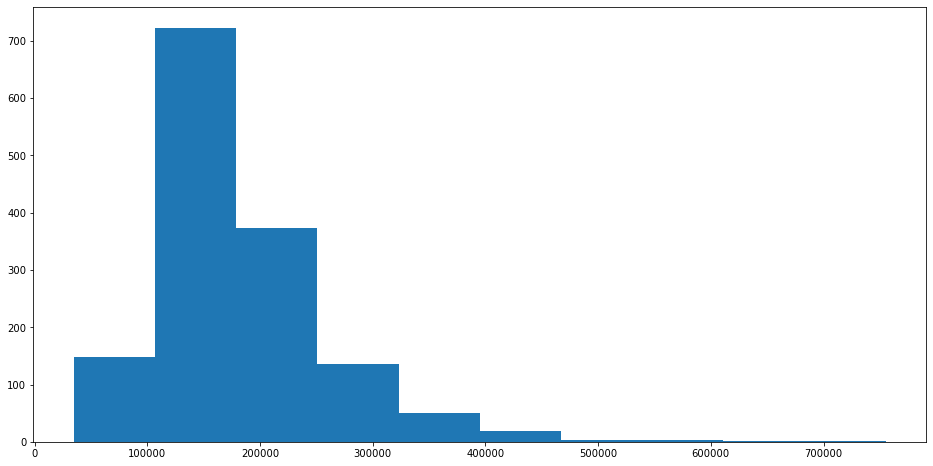

Average Sale Price in Aimes: $ 180921.2
Variation in Sale Price: $ 79415.29


In [3]:
#target variable
y =train["SalePrice"]
fig, ax = plt.subplots(figsize=(16, 8)) 
plt.hist(y)
plt.show()

print(f"Average Sale Price in Aimes: $ {round(np.mean(y),2)}")
print(f"Variation in Sale Price: $ {round(np.std(y),2)}")

on droping columns with missing values features are reduced to 61 columns from 80 columns


<AxesSubplot:>

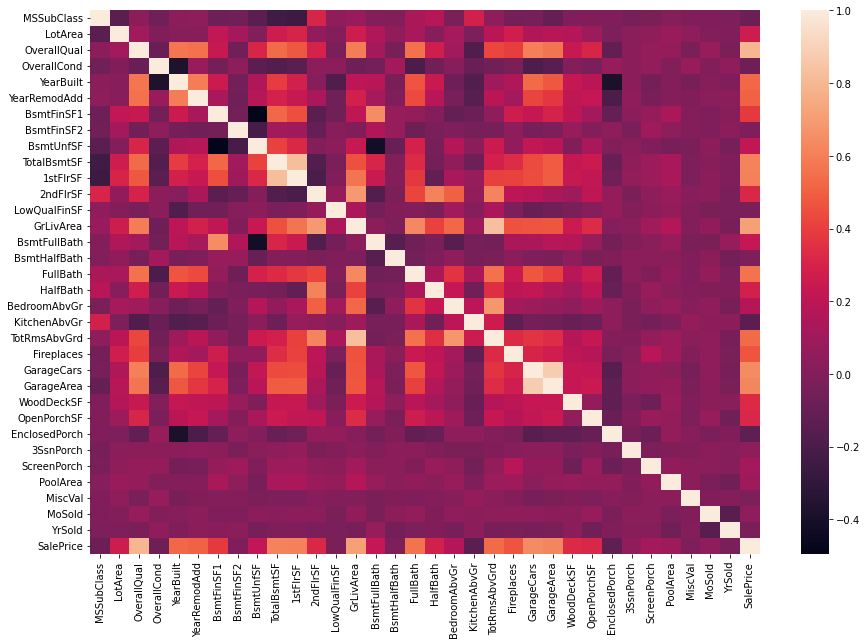

In [4]:
## Find features correlation to SalePrice 
train1 = train.copy().dropna(axis=1)

#Remove columns that have missing data
print(f"on droping columns with missing values features are reduced to {train1.shape[1]} columns from {train.shape[1]} columns")

#Look at correlation for continuous variables
plt.figure(figsize=(15,10))
sns.heatmap(train1.corr())

## Domain Knowledge

### seperate columns by types

In [5]:
#Nominal A variable that has no numerical importance, for example color or city.
categorical_columns_labels = ["MSSubClass", "MSZoning", "Street", "LotShape", "LandContour", "Utilities", 
                               "LotConfig",  "LandSlope", "Neighborhood", "Condition1", "Condition2", "BldgType",
                              "HouseStyle", "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", 
                             "Foundation", "Heating","CentralAir","Functional","PavedDrive","SaleType","SaleCondition"]

#Ordinal A variable that has some order associated with it like our place example above
categorical_columns_ranking = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtQual", "BsmtCond",
                              "BsmtExposure","HeatingQC","KitchenQual","FireplaceQu","GarageQual","GarageCond",
                              "PoolQC","Fence"]

#Nominal A variable that has no numerical importance, for example color or city.
categorical_columns_ordinal = ["BsmtFullBath", "BsmtHalfBath", "FullBath",
                              "HalfBath", "BedroomAbvGr","KitchenAbvGr","TotRmsAbvGrd", "Fireplaces",
                              "GarageCars","BsmtFinSF1","BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
                             "1stFlrSF","2ndFlrSF", "LowQualFinSF","BsmtFullBath"]

categorical_columns_year = ["YearBuilt", "YearRemodAdd", "MoSold","YrSold"]

continious_columns = ["LotArea","GrLivArea", "GarageArea","WoodDeckSF","OpenPorchSF",
                     "EnclosedPorch","3SsnPorch", "ScreenPorch", "PoolArea"]

continous_currency = ["MiscVal"]

In [6]:
le = preprocessing.LabelEncoder()

train2 = pd.DataFrame([])

for col in categorical_columns_labels:
    le.fit(train[col])
    train2[col] = le.transform(train[col])
    
print(train2.shape)
for col in categorical_columns_ordinal:
    le.fit(train[col])
    train2[col] = le.transform(train[col]) 
print(train2.shape)

for col in categorical_columns_ranking:
    le.fit(train[col])
    train2[col] = le.transform(train[col])
print(train2.shape)

scaler = RobustScaler()
scaler.fit(train[continious_columns])
temp_train = pd.DataFrame(scaler.transform(train[continious_columns]), columns=continious_columns)
train2[continious_columns] = temp_train[continious_columns]
print(train2.shape)

(1460, 24)
(1460, 40)
(1460, 54)
(1460, 63)


In [7]:
le = preprocessing.LabelEncoder()

test2 = pd.DataFrame([])

for col in categorical_columns_labels:
    le.fit(test[col])
    test2[col] = le.transform(test[col])    
print(test2.shape)

for col in categorical_columns_ordinal:
    le.fit(test[col])
    test2[col] = le.transform(test[col]) 
print(test2.shape)

for col in categorical_columns_ranking:
    le.fit(test[col])
    test2[col] = le.transform(test[col])
print(test2.shape)

scaler = RobustScaler()
scaler.fit(test[continious_columns])
temp_test = pd.DataFrame(scaler.transform(test[continious_columns]), columns=continious_columns)
test2[continious_columns] = temp_test[continious_columns]
print(test2.shape)

(1459, 24)
(1459, 40)
(1459, 54)
(1459, 63)


In [8]:
list(test2.columns) == list(train2.columns) 

True

## Modelling

In [9]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, \
            StackingRegressor
from sklearn.metrics import r2_score,mean_squared_error,RocCurveDisplay, max_error
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
import sklearn.linear_model as lm

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train2,y, test_size=0.25, random_state=42)

## Feature Selection using Lasso

In [11]:
from sklearn.linear_model import LassoCV

reg = LassoCV(cv=5, random_state=42, fit_intercept=False).fit(X_train,y_train)
X_train.columns[reg.coef_>= 1e-9]

Index(['Neighborhood', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'ScreenPorch'],
      dtype='object')

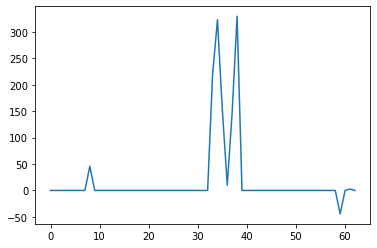

In [12]:
plt.plot(reg.coef_)
plt.show()


## Prediction using Regression

In [25]:
from sklearn.linear_model import HuberRegressor, LinearRegression
huber = HuberRegressor().fit(X_train[X_train.columns[reg.coef_>= 1e-9]], y_train)
y_pred_rgr = huber.predict(X_test[X_train.columns[reg.coef_>= 1e-9]])

print(f"HuberRegressor: R^2 = {r2_score(y_test, y_pred_rgr)}, max_error={max_error(y_test, y_pred_rgr) }");

from sklearn import linear_model
clf = linear_model.BayesianRidge().fit(X_train[X_train.columns[reg.coef_>= 1e-9]], y_train)
y_pred_rgr = clf.predict(X_test[X_train.columns[reg.coef_>= 1e-9]])

print(f"BayesianRidge 2Regressor: R^2 = {r2_score(y_test, y_pred_rgr)}, max_error={max_error(y_test, y_pred_rgr) }");

clf = linear_model.BayesianRidge().fit(X_train[X_train.columns[reg.coef_>= 1e-9]], y_train)
y_pred_rgr = clf.predict(X_test[X_train.columns[reg.coef_>= 1e-9]])

print(f"BayesianRidge 2Regressor: R^2 = {r2_score(y_test, y_pred_rgr)}, max_error={max_error(y_test, y_pred_rgr) }");

HuberRegressor: R^2 = 0.647093438210081, max_error=357040.8663434958
HuberRegressor: R^2 = 0.6723037309488863, max_error=345609.0133300406


C:\Users\GudiduriSS\Anaconda3\lib\site-packages\sklearn\linear_model\_huber.py:332: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


## Feature Selection using Trees

In [27]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=50)
clf = clf.fit(X_train, y_train)
min_val = np.min(clf.feature_importances_[clf.feature_importances_ < 5])
max_val = np.max(clf.feature_importances_)
X_train.columns[np.argwhere(clf.feature_importances_ > 0).reshape(-1)] 

Index(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'Foundation', 'Heating', 'CentralAir',
       'Functional', 'PavedDrive', 'SaleType', 'SaleCondition', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'FireplaceQu',
       'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'LotArea', 'GrLivArea',
       'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea'],
      dtype='object')

## Prediction using Trees

In [28]:
selected_features = X_train.columns[np.argwhere(clf.feature_importances_ > 0).reshape(-1)] 
X_train1 = X_train[selected_features]
X_test1 = X_test[selected_features]

regr = RandomForestRegressor(max_depth=200, random_state=42)
adr = AdaBoostRegressor(n_estimators=200, random_state=42)
gdr = GradientBoostingRegressor(n_estimators=200, random_state=42)

regr.fit(X_train1, y_train)
adr.fit(X_train1, y_train)
gdr.fit(X_train1, y_train)

y_pred_rgr = regr.predict(X_test1)
y_pred_adr = adr.predict(X_test1)
y_pred_gdr = gdr.predict(X_test1)
    
#metrics for exlaining  R^2 adj R^2,  metrics for model performance testing MSE, RMSE, MAE
print(f"RandomForestRegressor: R^2 = {r2_score(y_test, y_pred_rgr)}, max_error={max_error(y_test, y_pred_rgr) }");
print(f"AdaBoostRegressor: R^2 = {r2_score(y_test, y_pred_adr)}, max_error={max_error(y_test, y_pred_adr) }");
print(f"GradientBoostingRegressor: R^2 = {r2_score(y_test, y_pred_gdr)}, max_error={max_error(y_test, y_pred_gdr) }");

RandomForestRegressor: R^2 = 0.8958563624395958, max_error=164129.64
AdaBoostRegressor: R^2 = 0.8480349609278369, max_error=192099.50230414746
GradientBoostingRegressor: R^2 = 0.9141929021478221, max_error=136813.7671536812


In [29]:
regr.predict(test2[selected_features].dropna()) 

array([127953.  , 157343.5 , 172030.82, ..., 157305.  , 116849.75,
       231398.65])

## Prediction using Neural Network

In [41]:
from sklearn.neural_network import MLPRegressor
regr = MLPRegressor(random_state=1, max_iter=1000, solver="lbfgs").fit(X_train1, y_train)
y_pred_rgr = regr.predict(X_test1)

print(f"Neural 2Regressor: R^2 = {r2_score(y_test, y_pred_rgr)}, max_error={max_error(y_test, y_pred_rgr) }");

Neural 2Regressor: R^2 = 0.7817216498377977, max_error=319499.58905345097


C:\Users\GudiduriSS\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
